# Predictive modeling: travel insurance

This notebook contains an analysis of data from 2019 about customers of a tour & travels company. This includes building a model that predicts whether the customer would be interested in a new travel insurance offering. Such a model could be used in practice in many ways, for example, to select the target audience for a marketing campaign of the new travel insurance offering.

**Goal: build a classifier to predict which customers would be interested in the new travel insurance offer.**

**Objectives**:
- Gain insight about the company's customers and the available data about them;
- Understand the relationships among different variables in the customers' data, and their implications;
- Train a predictive model that classifies which customers would be interested in buying the new travel insurance offer.

**Data (**[source](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)**)**:
- 1987 customers
- 8 predictors
    - 3 Discrete: Age, Income, Family size,
    - 5 Binary: Employment type, Graduate, Has chronic disease, Frequent flyer, Ever travelled abroad
- Response variable is binary (1 = customer bought travel insurance, 0 = didn't buy)

<br>

***

## TL;DR

**Data overview.** The most predictive features of customers' interest in travel insurance are income, and previous travel experience (whether they fly frequently and have travelled abroad before). Employment sector is also somewhat indicative. Perhaps unexpectedly, customer's age is not very predictive in this case, however there's very little diversity in that regard, as the range is just 11 years, so this <u>dataset isn't very representative of the population</u>.

**Classification model.** A lack of continuous variables and relatively low spread of the data resulted in this small dataset having no outliers, but a lot of duplicates (almost 33%). This has affected our model choice. We chose <u>recall as our main metric</u>, and compared six classifier models, including ensembles, optimising the hyperparameters of each. We found that a <u>stacking ensemble model</u> combining a logistic regression, k-nearest neighbors, and an SVM ensures the best recall and good generalisation. The model performance metrics on a hold-out dataset were:
- 67% recall (meaning it correctly identifies 2/3 of customers likely to be interested in the new travel insurance offer)
- 54% precision
- 68% accuracy
- 74% AUC

**Pipeline.** Only about 36% of labels in the training dataset were positive. To tackle this imbalance, we added the synthetic minority oversampling technique (SMOTE) to the pipeline, which has significantly improved the performance of all models we considered.


<br>

***

## Table of contents

Main sections of this notebook:
1. [About the dataset](#1.-About-the-dataset)<br>
2. [Exploratory analysis](#2.-Exploratory-analysis)<br>
    2.1. [Variables overview & encoding](#2.1.-Variables-overview-&-encoding)<br>
    2.2. [Discrete variables](#2.2.-Discrete-variables)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;2.2.1. [Age](#2.2.1.-Age)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;2.2.2. [Annual income](#2.2.2.-Annual-income)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;2.2.3. [Family members](#2.2.3.-Family-members)<br>
    2.3. [Binary variables](#2.3.-Binary-variables)<br>
    2.4. [Duplicates](#2.4.-Duplicates)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;2.4.1. [Discrete variables](#2.4.1.-Discrete-variables)<br>
        &nbsp;&nbsp;&nbsp;&nbsp;2.4.2. [Binary variables](#2.4.2.-Binary-variables)<br>
    2.5. [Outliers](#2.5.-Outliers)<br>
    2.6. [Correlations](#2.6.-Correlations)<br>
3. [Model selection](#3.-Model-selection)<br>
    3.1. [Multicollinearity](#3.1.-Multicollinearity)<br>
    3.2. [Baseline models comparison](#3.2.-Baseline-models-comparison)<br>
    3.3. [Hyperparameter tuning](#3.3.-Hyperparameter-tuning)<br>
    3.4. [Final model overview](#3.4.-Final-model-overview)<br>
    3.5. [Final model evaluation](#3.5.-Final-model-evaluation)<br>
    3.6. [Opportunities for improvement](#3.6.-Opportunities-for-improvement)<br>

<br>

***

## 1. About the dataset

Let's load the libraries, the data, and set up the notebook before investigating the data itself:

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import (encode, stats_overview, get_ci_mean,
                      get_ci_proportion, binary_var_proportions,
                      check_outliers, corr_heatmap, check_vif, grid_cv)

from scipy.stats import sem, t, ttest_ind, chi2_contingency
from statsmodels.stats import proportion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.model_selection import (train_test_split, cross_validate,
                                    StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import (recall_score, precision_score, 
                            accuracy_score, f1_score,
                            ConfusionMatrixDisplay, confusion_matrix,
                            PrecisionRecallDisplay, precision_recall_curve,
                            RocCurveDisplay)

os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
global_palette = "coolwarm"
pd.set_option("display.float_format", "{:.2f}".format)
sns.set_theme(
    context="notebook",
    style="whitegrid",
    rc={f"axes.spines.{side}": False for side in [
        "top","bottom","left","right"
    ]}, 
    palette=sns.color_palette(global_palette)
)

data = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)

We can now inspect the size and variables in this dataset:

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 155.2+ KB


We can immediately see that the dataset is already quite clean: there are no nan values, and in the EDA section below we found no other values (such as blanks) that could indicate any missing data.

Here's a description of all the variables:
- **Age**: customer's age in years
- **Employment Type**: either government sector, or private/self-employed.
- **GraduateOrNot**: whether the customer has graduated college or not.
- **AnnualIncome**: customer's income rounded down to the nearest 100k or 50k.
- **FamilyMembers**: number of members in the customer's family.
- **ChronicDiseases**: whether the customer has some chronic disease or not (e.g. diabetes, high blood pressure, asthma).
- **FrequentFlyer**: whether the customer has booked flight tickets at least 4 different instances in the last 2 years (2017-2019).
- **EverTravelledAbroad**: whether the customer has ever travelled to a foreign country (via this company or otherwise).
- **TravelInsurance**: whether the customer has bought the new travel insurance package during the recent introductory offering in 2019.

This is a relatively small dataset with under 2,000 instances, and 8 independent variables. Because the dataset is so small, we'll allocate 80% of the data to training, and use cross-validation to make sure we use as much data as possible for training:

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=83, 
                                         stratify=data["TravelInsurance"])
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 1589
Test data size: 398


<br>

***

## 2. Exploratory analysis

In this section we will transform variables, analyse them and their relationships, address several hypotheses about the data by conducting statistical tests. At the end of this section, we'll have a good understanding of the customers in this dataset and how different features of these customers interact with each another.

<br>

***

### 2.1. Variables overview & encoding

Here's a statistical description of the numerical variables:

In [4]:
train_data.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1589.00,1589.00,1589.00,1589.00,1589.00
mean,29.61,932158.59,4.76,0.28,0.36
std,2.91,378559.26,1.59,0.45,0.48
min,25.00,300000.00,2.00,0.00,0.00
25%,28.00,600000.00,4.00,0.00,0.00
50%,29.00,900000.00,5.00,0.00,0.00
75%,32.00,1250000.00,6.00,1.00,1.00
max,35.00,1800000.00,9.00,1.00,1.00


Among the numerical variables, there's a combination of discrete and binary values. Even annual income is rounded down into just 30 discrete values, as we can see below, where we count the number of unique values in each variable:

In [5]:
for feature in train_data.columns:
    print(f"{len(train_data[feature].unique()):<2} unique values in {feature}")

11 unique values in Age
2  unique values in Employment Type
2  unique values in GraduateOrNot
30 unique values in AnnualIncome
8  unique values in FamilyMembers
2  unique values in ChronicDiseases
2  unique values in FrequentFlyer
2  unique values in EverTravelledAbroad
2  unique values in TravelInsurance


Most of the variables are actually binary, some of which are numerical and others categorical. Here are the values in each binary variable:

In [6]:
binary_cols = []
print("Unique values per binary variable")
for feature in train_data.columns:
    if len(train_data[feature].unique()) == 2:
        print(f"{feature:<19}: {(train_data[feature].unique())}")
        binary_cols.append(feature)

Unique values per binary variable
Employment Type    : ['Private Sector/Self Employed' 'Government Sector']
GraduateOrNot      : ['Yes' 'No']
ChronicDiseases    : [0 1]
FrequentFlyer      : ['No' 'Yes']
EverTravelledAbroad: ['No' 'Yes']
TravelInsurance    : [0 1]


For modeling purposes, it will be beneficial to encode all these values into [0, 1]. This will ensure that all binary values are formatted the same way, and that all variables in the dataset are numerical. We'll use a custom function "encode" to do this:

In [7]:
continuous_cols = list(train_data.columns.difference(binary_cols))
binary_preprocessor = FunctionTransformer(encode)
preprocessor = make_column_transformer(
    ("passthrough", continuous_cols),
    (binary_preprocessor, binary_cols),
)

pipe = Pipeline([
    ("preprocessor", preprocessor)
])

train_data = pd.DataFrame(pipe.fit_transform(train_data), 
                          columns=continuous_cols+binary_cols, 
                          index=train_data.index)

For *Employment Type*, we've encoded *Private Sector/Self Employed* as 0, and *Government Sector* as 1.

<br>

***

### 2.2. Discrete variables

We'll explore Age, AnnualIncome, and FamilyMembers.

<br>

#### 2.2.1. Age

Age                                         
                  count  mean  std   min   25%   50%   75%   max
TravelInsurance                                                 
0               1021.00 29.49 2.64 25.00 28.00 29.00 31.00 35.00
1                568.00 29.83 3.33 25.00 27.00 29.00 33.00 35.00

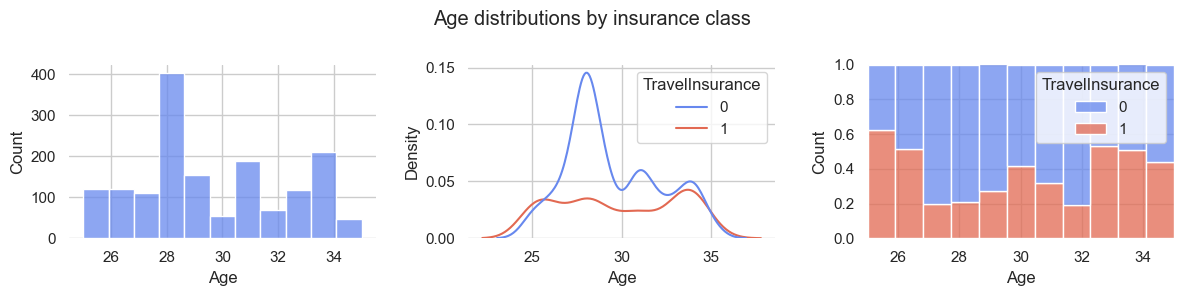

In [8]:
stats_overview(train_data, "Age", global_palette)

There's not much age diversity, the range is just [25-35]. Of almost 1,600 customers, about 400 are 28 years old. Most of those 28-year-olds did not buy travel insurance, however, there is no clear correlation between age and insurance purchases. Customers aged 25-26 and 33+ purchased insurance more often than those in the mid-range, but the proportions fluctuate quite a bit. The age means between the two TravelInsurance groups is similar as well. Those who bought the insurance are on average just 0.34 years older than those who didn't.

<u>Let's check if this difference of the means (29.49 and 29.83) is statistically significant.</u>

- Null hypothesis: Customers who bought insurance are on average the same age or younger than those who didn't.
- Confidence level: 95%

We'll first calculate the confidence intervals of each mean:

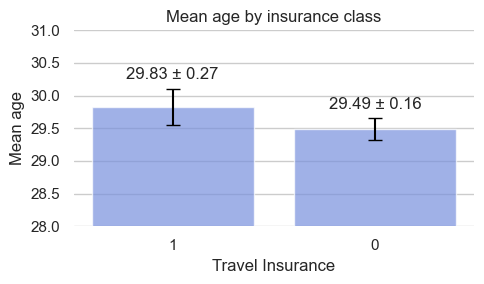

In [9]:
age_no = train_data[train_data["TravelInsurance"] == 0]["Age"]
age_yes = train_data[train_data["TravelInsurance"] == 1]["Age"]

means = [age_yes.mean(), age_no.mean()]
margins = []
for category in [age_yes, age_no]:
    margins.append(round(get_ci_mean(category)[0],4))

plt.figure(figsize=(5,3))
ax = sns.barplot(x=[1,0], y=means, order=[1,0], alpha=0.7)
ax.set_ylim([28, 31])
ax.errorbar(x=range(2), y=means, yerr=margins, 
            fmt="none", capsize=5, color="black")

for i, (mean, margin) in enumerate(zip(means, margins)):
    ax.text(i, mean + margin + 0.1, f"{round(mean,2)} ± {margin:.2f}", 
            ha="center", va="bottom")

plt.ylabel("Mean age")
plt.xlabel("Travel Insurance")
plt.title("Mean age by insurance class")
plt.tight_layout()

At 95% confidence, these intervals overlap a bit. But what about the confidence interval for the difference between these means?

In [10]:
mean_diff = means[0] - means[1]
se_diff = (sem(age_yes)**2 + sem(age_no)**2)**0.5
ci_margin = t.ppf((1 + 0.95) / 2, df=len(age_yes)-1) * se_diff
print("95% CI for the difference between means: " + 
      f"{round(mean_diff - ci_margin,2)} – " + 
      f"{round(mean_diff + ci_margin,2)}")

95% CI for the difference between means: 0.02 – 0.66


This confidence interval doesn't include 0, which means that the difference is significant. We can prove this with a Student's t test:

In [11]:
t, p = ttest_ind(age_yes, age_no)
p = p/2 if t > 0 else 1-(p/2)

print(f"T-statistic: {t:.3f}, p-value: {p:.3f}")

T-statistic: 2.223, p-value: 0.013


With the p-value under 0.05, we can reject the null hypothesis. Customers who bought travel insurance are on average older than those who didn't buy it.

<br>


#### 2.2.2. Annual income

AnnualIncome                                           \
                       count       mean       std       min       25%   
TravelInsurance                                                         
0                    1021.00  816797.26 327474.63 300000.00 550000.00   
1                     568.00 1139524.65 376035.13 300000.00 800000.00   

                                                  
                       50%        75%        max  
TravelInsurance                                   
0                800000.00 1100000.00 1750000.00  
1               1300000.00 1400000.00 1800000.00

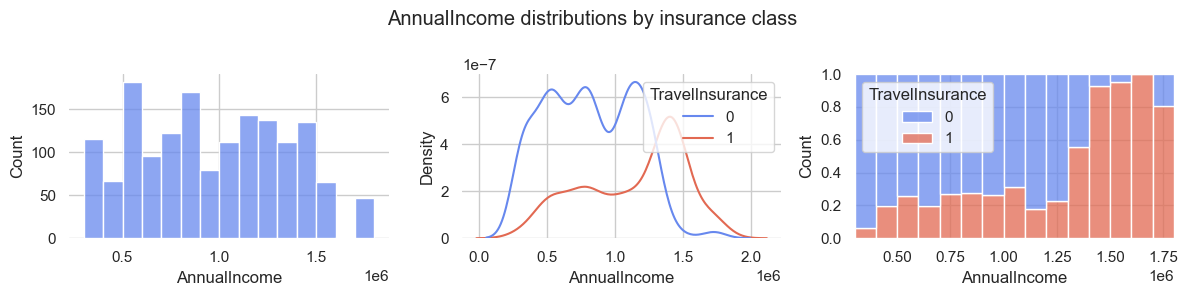

In [12]:
stats_overview(train_data, "AnnualIncome", global_palette)

Annual income ranges from 300k to 1,800k. The overall distribution is approximately normal, and there's a clear difference in income for customers who bought insurance versus those who didn't. These distributions are clearly distinct. Almost all customers who earn 1,400k+ bought insurance, while most people on the lower end of the income range didn't buy it. The income means are clearly distinct too: 817k vs 1,140k.

<br>


#### 2.2.3. Family members

FamilyMembers                                   
                        count mean  std  min  25%  50%  75%  max
TravelInsurance                                                 
0                     1021.00 4.69 1.57 2.00 4.00 4.00 6.00 9.00
1                      568.00 4.89 1.63 2.00 4.00 5.00 6.00 9.00

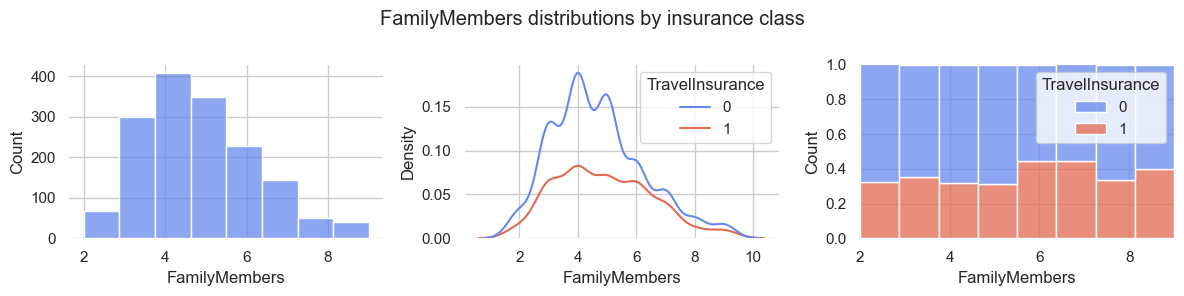

In [13]:
stats_overview(train_data, "FamilyMembers", global_palette)

Number of family members ranges from 2 to 9, with a left-skewed distribution that peaks at 4. It doesn't seem that this variable affects the customers' likelihood to buy travel insurance, as the distributions look very similar, and the means differ by just 0.2 with those who purchased insurance having slighly larger families on average.

<u>Let's check if this difference is statistically significant by binning the customers into two groups: small families (2-4) and large families (5-9).</u>

- Null hypothesis: Proportion of customers from large families who bought insurance is lower or equal to the same proportion of customers from small families.
- Confidence level: 95%

Again, we'll start with the confidence intervals for each group:

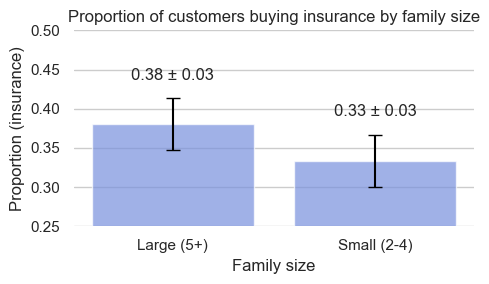

In [14]:
large_fam = train_data[train_data["FamilyMembers"] >= 5]["TravelInsurance"]
small_fam = train_data[train_data["FamilyMembers"] < 5]["TravelInsurance"]

margin_large, p_large = get_ci_proportion(large_fam)
margin_small, p_small = get_ci_proportion(small_fam)
margins = [margin_large, margin_small]
p_hats = [p_large, p_small]
labels = ["Large (5+)","Small (2-4)"]
plt.figure(figsize=(5,3))
ax = sns.barplot(x=labels, y=p_hats, order=labels, alpha=0.7)
ax.set_ylim([0.25, 0.5])
ax.errorbar(x=range(2), y=p_hats, yerr=margins, 
            fmt="none", capsize=5, color="black")

for i, (mean, margin) in enumerate(zip(p_hats, margins)):
    ax.text(i, mean + margin + 0.02, f"{round(mean,2)} ± {margin:.2f}", 
            ha="center", va="bottom")

plt.ylabel("Proportion (insurance)")
plt.xlabel("Family size")
plt.title("Proportion of customers buying insurance by family size")
plt.tight_layout();

Again, the confidence intervals for these proportions overlap (0.35-0.41 and 0.30-0.36). Let's test this difference using a one-tailed two-proportion Z test:

In [15]:
yes = [sum(large_fam), sum(small_fam)]
n = [len(large_fam), len(small_fam)]

z, p = proportion.proportions_ztest(yes, n)
p = p/2 if z > 0 else 1-(p/2)
print(f"Z-statistic: {z:.3f}, p-value: {p:.4f}")

Z-statistic: 1.925, p-value: 0.0271


After testing in one direction at 95% confidence, we can reject the null hypothesis and conclude that it's indeed very likely that customers from large families buy travel insurance more often than customers from small families.

<br>

***

### 2.3. Binary variables

We'll now take a closer look at the remaining variables, all of which are binary. First, let's check the value counts and percentages in each binary variable:

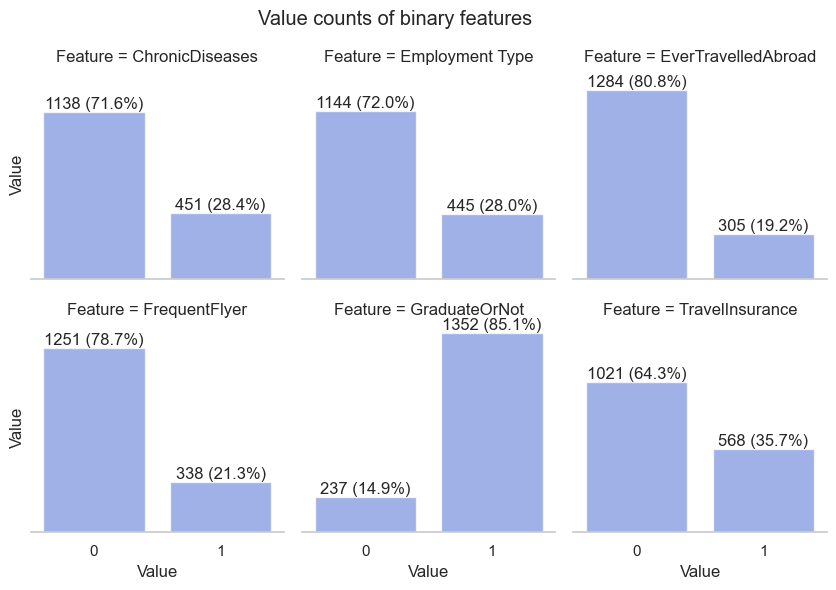

In [16]:

counts_data = train_data[binary_cols].melt(
    var_name="Feature", 
    value_name="Value"
)
percentages = counts_data.groupby("Feature").mean()
grid = sns.FacetGrid(counts_data, col="Feature", col_wrap=3, sharex=True, 
                     sharey=True, col_order=list(percentages.index))

grid.map_dataframe(sns.barplot, x="Value", y="Value", 
                   alpha=0.7, estimator=lambda x: len(x))
for ax in grid.axes.flat:
    total = sum(p.get_height() for p in ax.patches)
    labels = [f"{int(p.get_height())} ({(p.get_height() / total) * 100:.1f}%)"
              for p in ax.patches]
    ax.bar_label(ax.containers[0], labels=labels, label_type="edge")
    ax.grid(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_ticks([])
plt.suptitle("Value counts of binary features")
plt.subplots_adjust(top=0.88);

The counts of binary categories are imbalanced in all variables. The dependent variable is actually the least imbalanced, and even there the number of customers who bought insurance is almost 2x lower than the number of customers who didn't buy it.

Interestingly, only 21% of customers are frequent flyers, and only 19% have ever travelled abroad (note that this data is from India, where domestic flights are usual). Let's see how these variables) are related to the dependent variable:

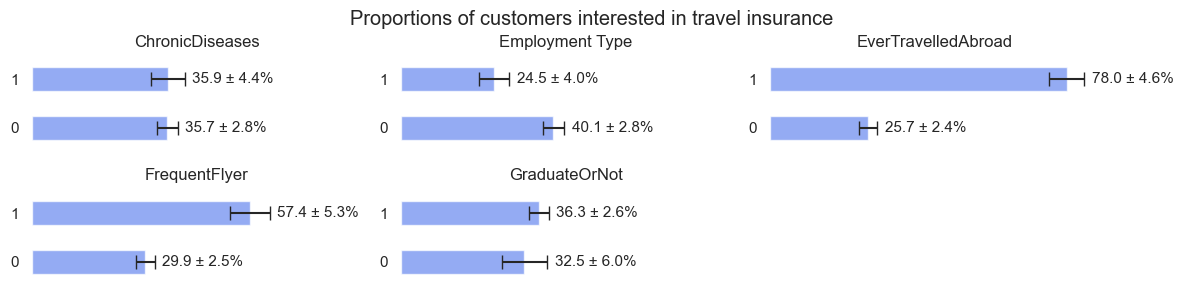

In [17]:
binary_var_proportions(train_data[binary_cols])
plt.suptitle("Proportions of customers interested in travel insurance");

- As expected, most customers who are frequent flyers or have ever travelled abroad did buy travel insurance, and vice-versa.
- Regardless of whether the customer is a college graduate or has any chronic diseases, the percentage of insurance purchases is similar in those groups, and their confidence intervals clearly overlap.
- There's a significant difference in customers employed in the government sector (they bought insurance less often) and private sector / self-employed (they bought it more often). This could be related to the fact that those in government sector tend to earn less, as seen below:

In [18]:
train_data[[
    "Employment Type", "AnnualIncome"
]].groupby("Employment Type").mean().round(0).astype(int)

,AnnualIncome
Employment Type,
0,1015297
1,718427


This doesn't mean that employment type in itself isn't useful in predicting interest in travel insurance (as we'll see later, it's still a useful predictor despite its correlation with income).

What's more interesting is the relationship between graduation status and the dependent variable. The confidence intervals in the graduation categories overlap, but there's still some difference in the estimates, so it's worth exploring this further.

In [19]:
train_data[[
    "GraduateOrNot", "AnnualIncome"
]].groupby("GraduateOrNot").mean().round(0).astype(int)

,AnnualIncome
GraduateOrNot,
0,842194
1,947929


As expected, college graduates earn a bit more on average. But do insurance purchases depend on graduation status? 

<u>Below, we'll check if there's a statistical difference in insurance purchases based on graduation status.</u>

- Null hypothesis: A customer's interest in travel insurance isn't affected by whether they're a college graduate or not.
- Confidence level: 95%

We'll test this by using a contingency table of travel insurance and graduation status variables...

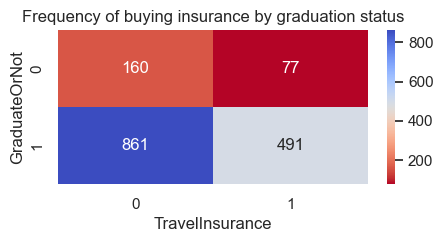

In [20]:
table = pd.crosstab(train_data["GraduateOrNot"], train_data["TravelInsurance"])
plt.figure(figsize=(5,2))
sns.heatmap(table, annot=True, fmt=".0f", cmap=f"{global_palette}_r")
plt.title("Frequency of buying insurance by graduation status");

...and the chi-squared test for contingency tables:

In [21]:
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-squared: {chi2:.3f}, p-value: {p:.3f}")

Chi-squared: 1.125, p-value: 0.289


With 95% confidence, we failed to reject the null hypothesis. There's no sufficient proof that graduation status affects insurance purchases.

<br>

***

### 2.4. Duplicates

Let's check if there are any duplicates in the training data:

In [22]:
duplicates = train_data[train_data.duplicated()]
duplicate_count = len(duplicates)
print(f"{duplicate_count} duplicates " + 
      f"({round(100*duplicate_count/len(train_data),2)}%)")

518 duplicates (32.6%)


Almost one third of instances are duplicates! This seems plausible considering that there are no continuous variables, so the number of possible value combinations is relatively limited. So we will definitely not drop these duplicates, also because they make up such a huge portion of the data we have.

However, we still need to explore them more closely. It's important to understand how the distributions of duplicates differ compared to the rest of the data. For example, if the duplicates represented just a small subset of values in the data, that could have major implications when training a prediction model.

<br>

#### 2.4.1. Discrete variables

We'll first look at discrete variables:

In [23]:
duplicate_stats = []
for feature in ["Age", "AnnualIncome", "FamilyMembers"]:
    stats_table = duplicates[[
        feature, "TravelInsurance"
    ]].groupby("TravelInsurance")[feature].describe()
    stats_table.index = [
        f"({feature}) Insurance: {i}" for i in stats_table.index
    ]
    duplicate_stats.append(stats_table)
pd.concat(duplicate_stats)

,count,mean,std,min,25%,50%,75%,max
(Age) Insurance: 0,355.00,29.40,2.50,25.00,28.00,28.00,31.00,35.00
(Age) Insurance: 1,163.00,29.55,3.56,25.00,26.00,29.00,33.00,35.00
(AnnualIncome) Insurance: 0,355.00,769295.77,331791.59,300000.00,500000.00,800000.00,1100000.00,1700000.00
(AnnualIncome) Insurance: 1,163.00,1268711.66,355949.69,300000.00,1100000.00,1400000.00,1500000.00,1700000.00
(FamilyMembers) Insurance: 0,355.00,4.55,1.26,2.00,4.00,4.00,5.00,9.00
(FamilyMembers) Insurance: 1,163.00,4.50,1.29,2.00,3.00,4.00,5.50,9.00


A slighly smaller share of duplicates (163/518=31%) represent customers who bought insurance, compared to the whole training dataset (36%), refer to [2.2. Discrete variables](#2.2.-Discrete-variables).

Duplicates cover almost the full range of values across all three variables. The means and medians do differ a bit, for example, the mean family members is slighly higher among customers who didn't buy insurance when looking at duplicates alone. Here's a visual representation of the distributions in these variables:

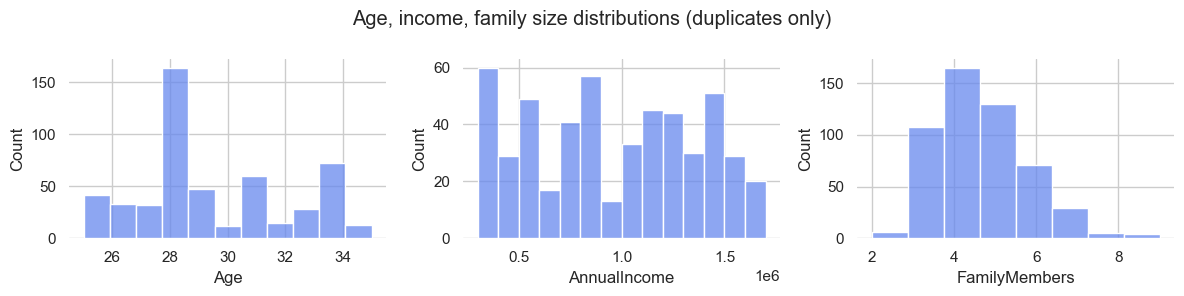

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.suptitle("Age, income, family size distributions (duplicates only)")
for feature, ax in zip(["Age", "AnnualIncome", "FamilyMembers"], axes):
    bin_size = min(len(duplicates[feature].unique()),14)
    sns.histplot(duplicates, ax=ax, x=feature, bins=bin_size)
plt.tight_layout();

Distributions of duplicates are also different, but they still somewhat resemble the full data.

<br>

#### 2.4.2. Binary variables

Now, let's check the proportions of customers who bought insurance in each binary variable, and compare them bertween duplicates and the whole training dataset:

In [25]:
duplicate_counts_data = duplicates[binary_cols].melt(
    var_name="Feature", value_name="Value"
).groupby("Feature").mean()
duplicate_counts_data.rename(columns={"Value": "Duplicates"}, inplace=True)
duplicate_counts_data["All train data"] = counts_data.groupby("Feature").mean()
duplicate_counts_data

,Duplicates,All train data
Feature,,
ChronicDiseases,0.19,0.28
Employment Type,0.26,0.28
EverTravelledAbroad,0.18,0.19
FrequentFlyer,0.16,0.21
GraduateOrNot,0.87,0.85
TravelInsurance,0.31,0.36


Among binary features we also see some differences in proportions, but nothing extreme. Let's check the insurance percentages per value in each binary variable:

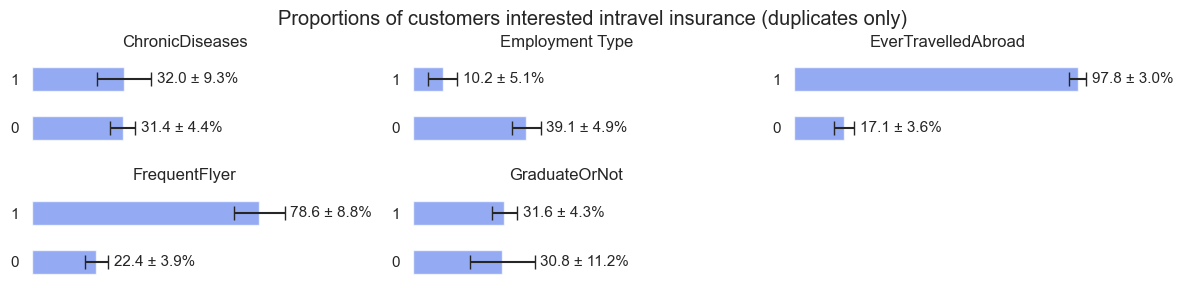

In [26]:
binary_var_proportions(duplicates[binary_cols])
plt.suptitle("Proportions of customers interested in" +
             "travel insurance (duplicates only)");

Same as above, we see some differences, e.g.:
- 10% in government sector among duplicates vs 24.5% across all data
- 98% among those who travelled abroad among duplicates vs 78% across all data
- 79% among frequent flyers in duplicates, vs 57% across all data

So certainly some groups of customers are under or over-represented, but not so much as to reverse the trend or suggest completely different assumptions about the whole dataset. For reference, see [2.3. Binary variables](#2.3.-Binary-variables)

<br>

***

### 2.5. Outliers

Another important aspect of data is outliers. This isn't relevant for binary variables, but we can still check if any values within the numeric discrete variables could be considered as outliers using the IQR rule:

In [27]:
outliers = []
for feature in continuous_cols:
    outliers.append(check_outliers(train_data[continuous_cols], feature))

for feature, i in zip(continuous_cols, outliers):
    try:
        print(f"{len(i)} ({round(len(i)/len(train_data) * 100, 1)}%)",
              f"outliers in {feature}")
    except TypeError:
        print(f"0 outliers in {feature}")

0 outliers in Age
0 outliers in AnnualIncome
0 outliers in FamilyMembers


There are no outliers in either of the discrete variables.

<br>

***

### 2.6. Correlations

We already saw some indications of correlation among variables above. We can quantify these correlations – both among the predictors, and between the predictors and the response – using Pearson's R and the Phi-K coefficient:
> **Pearson's R** is a linear correlation coefficient ranging from -1 to 1, where -1 and 1 represent perfect correlation (negative and positive, respectively), and 0 represents no correlation at all.
>
> **Phi K** is a correlation coefficient that can capture non-linear relationships and works well with binary data. Phi-K coefficients values range from 0 to 1 where 0 is no correlation and 1 is perfect correlation.

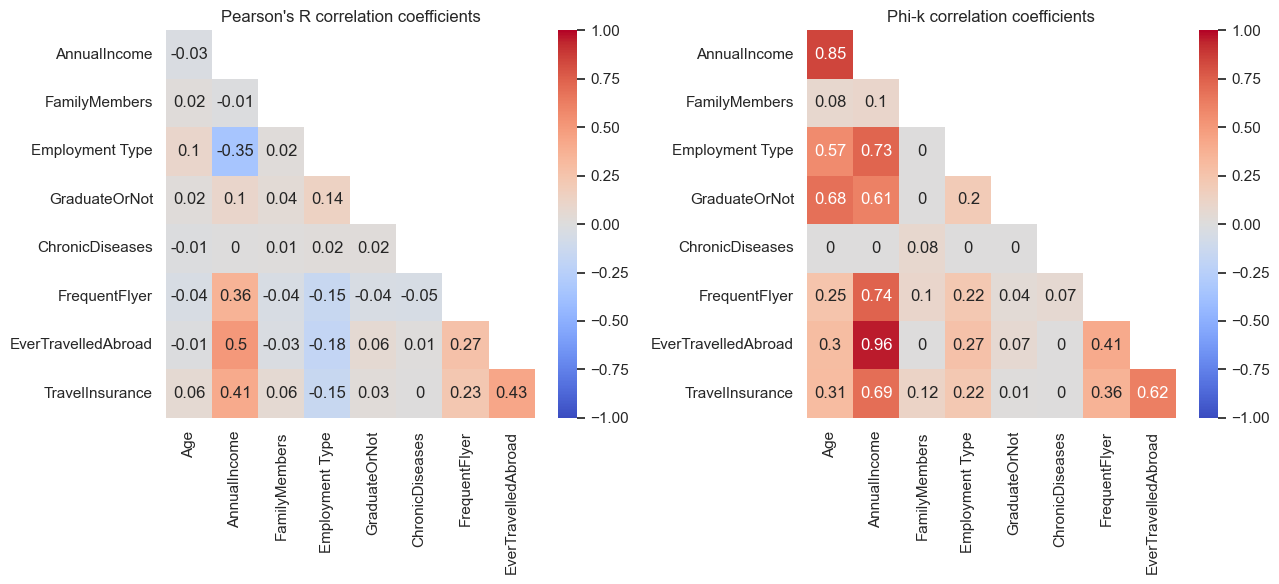

In [28]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
ax = sns.heatmap(
    data=corr_heatmap(train_data, "pearson").iloc[1:,:-1], 
                 vmin=-1, vmax=1, annot=True, cmap=global_palette)
ax.grid(False)
plt.title("Pearson's R correlation coefficients");
plt.subplot(1,2,2)
ax = sns.heatmap(data=corr_heatmap(train_data, "phik").iloc[1:,:-1], 
                 vmin=-1, vmax=1, annot=True, cmap=global_palette)
ax.grid(False)
plt.title("Phi-k correlation coefficients")
plt.tight_layout();

Looking at Pearson's R:
* The response is moderately correlated with variables AnnualIncome and EverTravelledAbroad. Both correlations are positive.
* There are also a number of correlations between predictors, the strongest ones all involve AnnualIncome, which is correlated with EverTravelledAbroad (0.5), GrequentFlyer (0.36), and Employment Type (-0.35).
* Most other correlations are very weak, and some variables don't have any correlations with other variables that would have a coefficient stronger than 0.1, such as ChronicDiseases, Age, and FamilyMembers.

According to Phi-K:
* Age is quite strongly correlated with multiple variables like income, employment type, and the GraduateOrNot variable.
* Income is also more strongly correlated with most values binary variables, and very strongly correlated with income and EverTravelledAbroad variable.

In the next part, we'll check the relationships between these variables in terms of multicollinearity too.

<br>

***

## 3. Model selection

In this section, we'll select and evaluate a model to predict whether a customer bought travel insurance or not, and incorporate this model into the final pipeline before testing it all using the hold-out dataset.

<br>

***

### 3.1. Multicollinearity

To check more specifically if there's multicollinearity and which variables are the most affected by it, we can use variance inflation factor (VIF).

> **VIF** can be calculated for each independent variable, and it measures how much its variance is impacted by fluctuations in other independent variables. Generally, values of 10 or above are considered to indicate serious cases of multicollinearity, so we want those numbers to be as low as possible.

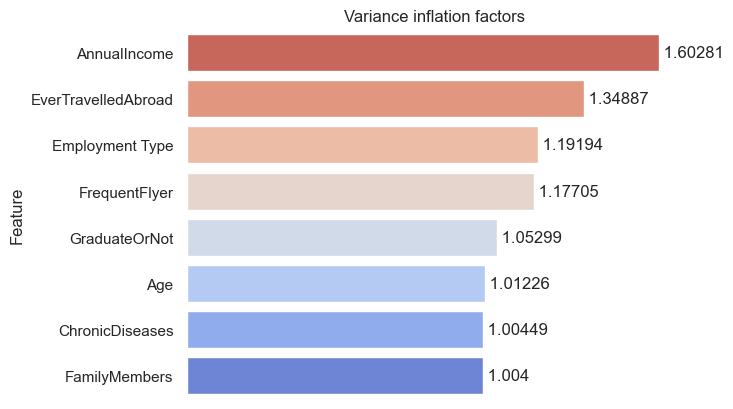

In [29]:
check_vif(train_data.drop(columns=["TravelInsurance"]), f"{global_palette}_r")

The VIF values are all very low, which means there isn't much multicollinearity among the independents variables, and there's no reason to remove any variables due to correlations with other predictor variables.

On a similar note, we've tried training some models below on a smaller dataset by removing variables which seem to be unrelated to the response, namely ChronicDiseases and FamilyMembers, but this results in a much worse performance, so in the end we decided to keep all the variables in.

<br>

***

### 3.2. Baseline models comparison

Here's an overview of the strategy we chose for this classification problem:

**The models**

To find the best model for predicting customers' interest in travel insurance, we'll start off by comparing the performance of three different algorithms with default hyperparameters, as well as three ensemble classifiers which combine the previously mentioned three algorithms in different ways. In total, that's six models we'll be choosing from:
- Logistic regression
- K-nearest neighbors
- Support vector machine
- Voting ensemble (hard)
- Voting ensemble (soft)
- Stacking ensemble

These are the types of models that should perform well on our small and unbalanced dataset with no outliers, but lots of duplicates.

**Smote**

We'll try to boost the performance of all these models by adding a SMOTE algorithm to the pipeline. SMOTE stands for synthetic minority oversampling technique – it will create synthetic instances of customers who have bought insurance to account for the fact that there are twice as many customers in the real data that didn't buy it. Equalising the number of instances among both groups allows the model to better learn information about the positive cases, as otherwise these models may have a hard time learning about under-represented classes.

**Target metric: Recall**

We'll choose the best model by comparing recall instead of accuracy. That's because the main end-goal is for the company to be able predict customers who would be interested in travel insurance, and recall describes precisely that. Other metrics like accuracy or precision balance out the success in predicting positive and negative labels, but in this case we aren't interested in the negative labels at all, as long as we can avoid too many false positives. We'll tackle that after we optimise for recall.

In [30]:
binary_preprocessor = FunctionTransformer(encode)
continuous_preprocessor = MinMaxScaler()

preprocessor = make_column_transformer(
    (continuous_preprocessor, continuous_cols),
    (binary_preprocessor, binary_cols[:-1]),
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

models = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Voting (hard)": VotingClassifier(estimators=[
        ("lr", LogisticRegression()),
        ("knn", KNeighborsClassifier()),
        ("svm", SVC())
    ], voting="hard"),
    "Voting (soft)": VotingClassifier(estimators=[
        ("lr", LogisticRegression()),
        ("knn", KNeighborsClassifier()),
        ("svm", SVC(probability=True))
    ], voting="soft"),
    "Stacking": StackingClassifier(estimators=[
        ("lr", LogisticRegression()),
        ("knn", KNeighborsClassifier()),
        ("svm", SVC())
    ], final_estimator=SVC(), cv=5),
}

scoring = ["accuracy", "recall"]

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=54)),
        ("classifier", model),
    ])
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore", category=FutureWarning)
        scores = cross_validate(
            pipe, X=train_data.drop(columns=["TravelInsurance"]),
            y=train_data["TravelInsurance"], cv=skf, scoring=scoring
        )

    print(f"{name}:")
    for metric in scoring:
        mean = scores[f"test_{metric}"].mean()
        std = scores[f"test_{metric}"].std()
        print(f"  {metric:<8} = {mean:.3f} ± {std:.3f}")

LR:
  accuracy = 0.736 ± 0.028
  recall   = 0.618 ± 0.047
KNN:
  accuracy = 0.731 ± 0.012
  recall   = 0.669 ± 0.021
SVM:
  accuracy = 0.776 ± 0.011
  recall   = 0.597 ± 0.011
Voting (hard):
  accuracy = 0.778 ± 0.007
  recall   = 0.599 ± 0.022
Voting (soft):
  accuracy = 0.761 ± 0.013
  recall   = 0.621 ± 0.017
Stacking:
  accuracy = 0.784 ± 0.013
  recall   = 0.588 ± 0.030


Different models have different strengths in terms of accuracy and recall. Since our goal is to maximise recall, k-nearest neighbors seems to perform the best, but it's also the worst model in terms of accuracy. As far as recall goes, it outperforms all the ensemble models as well.

Before we choose a single model, however, we'll check how far we can push each of these models and improve their performance by hyperparameter tuning.

<br>

***

### 3.3. Hyperparameter tuning

We'll use grid search cross validation to tune the hyperparameters each of model and plot a heatmap of recall values with each combination. We'll do this with all six models below, starting with logistic regression:

Best Recall: 0.62316
Parameters:
   classifier__C: 10
   classifier__penalty: l1
   classifier__solver: liblinear

CPU times: user 222 ms, sys: 178 ms, total: 400 ms
Wall time: 1.7 s


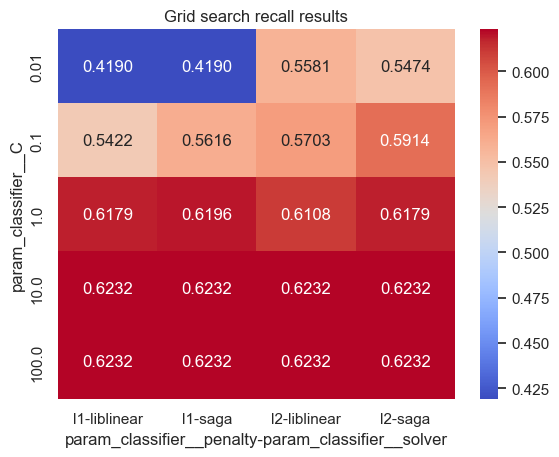

In [31]:
%%time

grid_cv(
    model=LogisticRegression(max_iter=1000, class_weight="balanced"), 
    param_grid={
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l1", "l2"],
        "classifier__solver": ["liblinear", "saga"],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, palette=global_palette
)

With logistic regression, we've tried checking different penalty and solver values, but none of the combinations performed better than the default l2 penalty with lbfgs solving algorithm. We've tried tuning C with lbfgs as well, with and without balanced class weights, but that yielded virtually the same results as what we see here with other solvers where C is 10 or higher. Either way, this is mcuh lower than the K-nearest neighbors classifier with default settings.

Speaking of which, let's tune the hyperparameters of our KNN classifier next:

Best Recall: 0.66896
Parameters:
   classifier__n_neighbors: 5
   classifier__p: 2
   classifier__weights: uniform

CPU times: user 619 ms, sys: 16.6 ms, total: 635 ms
Wall time: 1.02 s


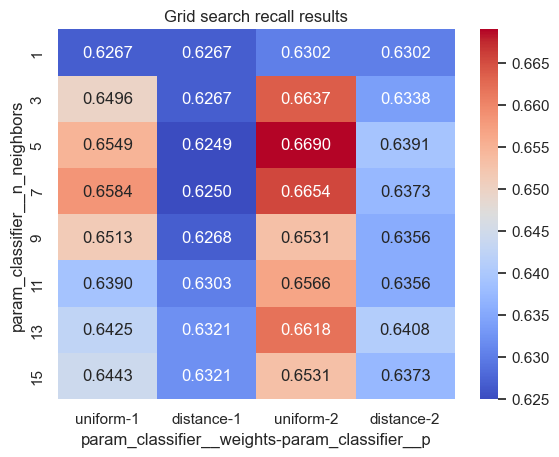

In [32]:
%%time

grid_cv(
    model=KNeighborsClassifier(),
    param_grid={
        "classifier__n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15],
        "classifier__weights": ["uniform", "distance"],
        "classifier__p": [1, 2],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, palette=global_palette
)

Turns out that the default hyperparameters for k-neighbors classifier provide the best performance in this case.

Let's see if the support vector machine with different hyperparameters can outperform it:

Best Recall: 0.60905
Parameters:
   classifier__C: 100
   classifier__gamma: auto
   classifier__kernel: rbf

CPU times: user 630 ms, sys: 18.9 ms, total: 649 ms
Wall time: 2.84 s


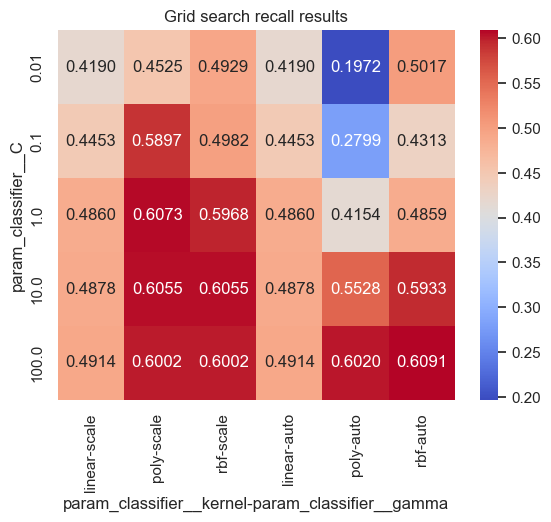

In [33]:
%%time

grid_cv(
    model=SVC(),
    param_grid={
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__kernel": ["linear", "poly", "rbf"],
        "classifier__gamma": ["scale", "auto"],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, palette=global_palette
)

Tuning the hyperparameters for SVC() only provided a marginal improvement in terms of recall.

Let's now try to tune each ensemble model in the same way, except we won't plot the heatmaps due to a very large number of hyperparameter combinations. We'll starting with the hard voting ensemble:

In [34]:
%%time

grid_cv(
    model=VotingClassifier(estimators=[
        ("lr", LogisticRegression(class_weight="balanced")),
        ("knn", KNeighborsClassifier()),
        ("svm", SVC(C=100)),
    ], voting="hard"),
    param_grid={
        "classifier__lr__solver": ["liblinear", "saga"],
        "classifier__lr__penalty": ["l1", "l2"],
        "classifier__lr__C": [0.1, 1, 10, 100],
        "classifier__knn__n_neighbors": [1, 3, 5, 7, 9],
        "classifier__knn__weights": ["uniform", "distance"],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, plotting=False
)

Best Recall: 0.61962
Parameters:
   classifier__knn__n_neighbors: 3
   classifier__knn__weights: uniform
   classifier__lr__C: 10
   classifier__lr__penalty: l1
   classifier__lr__solver: liblinear

CPU times: user 1.51 s, sys: 79.4 ms, total: 1.59 s
Wall time: 19.2 s


The hard voting ensemble with optimal hyperparameters provides 0.02 improvement to recall. This is more resource-heavy, but worse-performing than the simple k-nearest neighbors algorithm.

Next, we'll try the same with a soft voting classifier:

In [35]:
%%time

grid_cv(
    model=VotingClassifier(estimators=[
        ("lr", LogisticRegression(class_weight="balanced")),
        ("knn", KNeighborsClassifier()),
    ], voting="soft"),
    param_grid={
        "classifier__lr__solver": ["liblinear", "saga"],
        "classifier__lr__penalty": ["l1", "l2"],
        "classifier__lr__C": [0.1, 1, 10, 100],
        "classifier__knn__n_neighbors": [1, 3, 5, 7, 9],
        "classifier__knn__weights": ["uniform", "distance"],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, plotting=False
)

Best Recall: 0.65136
Parameters:
   classifier__knn__n_neighbors: 3
   classifier__knn__weights: uniform
   classifier__lr__C: 0.1
   classifier__lr__penalty: l2
   classifier__lr__solver: liblinear

CPU times: user 644 ms, sys: 36.1 ms, total: 680 ms
Wall time: 3.4 s


Here the SVM algorithm is omitted from the ensemble because this ensemble performs better than the one that includes an `SVC(probability=True)`. This classifier has a very similar recall to the KNN model, but it's slower to train.

Finally, we tune the hyperparameters for a stacking ensemble:

In [36]:
%%time

grid_cv(
    model=StackingClassifier(estimators=[
        ("lr", LogisticRegression(class_weight="balanced")),
        ("knn", KNeighborsClassifier()),
        ("svm", SVC()),
    ], final_estimator=KNeighborsClassifier(n_neighbors=7, weights="distance")),
    param_grid={
    "classifier__lr__solver": ["liblinear", "saga"],
    "classifier__lr__C": [0.01, 0.1, 1, 10, 100],
    "classifier__lr__penalty": ["l1", "l2"],
    "classifier__knn__n_neighbors": [1, 3, 5, 7, 9, 11],
    "classifier__knn__weights": ["uniform", "distance"],}, 
    data=train_data, cv=skf, preprocessor=preprocessor, plotting=False
)

Best Recall: 0.69014
Parameters:
   classifier__knn__n_neighbors: 9
   classifier__knn__weights: uniform
   classifier__lr__C: 0.1
   classifier__lr__penalty: l2
   classifier__lr__solver: liblinear

CPU times: user 2.59 s, sys: 203 ms, total: 2.79 s
Wall time: 54.5 s


The final classifier has been pre-defined here with previously cross-validated parameters to speed up this process when re-running or reproducing this code. We've also tried different algorithms as final estimators, and this is the best one.

It's the most complex model of them all, but we can see a marginal improvement in recall compared to the KNN model (0.67 vs 0.69). Although it's more memory-intensive and takes longer to train, the improvement is significant enough to choose this model versus the default K-nearest neighbors algorithm.

### 3.4. Final model overview

We'll now build a pipeline that includes the best performing classifier from the above:

In [37]:
model = StackingClassifier(estimators=[
        ("lr", LogisticRegression(
            C=0.1, solver="liblinear", class_weight="balanced"
        )),
        ("knn", KNeighborsClassifier(n_neighbors=9)),
        ("svm", SVC()),
], final_estimator=KNeighborsClassifier(n_neighbors=7, weights="distance"))

pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=54)),
        ("classifier", model),
    ])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'AnnualIncome',
                                                   'FamilyMembers']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function encode at 0x11c763ee0>),
                                                  ['Employment Type',
                                                   'GraduateOrNot',
                                                   'ChronicDiseases',
                                                   'FrequentFlyer',
                                                   'EverTravelledAbroad'])])),
                ('smote', SMOTE(random_state=54)),
                ('classifier',
                 StackingClassifier(estimators=[('lr',
                                                 LogisticRegression(C=0.1,
                                                                    class_weight='balanced',
                                                                    solver='liblinear')),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=9)),
                                                ('svm', SVC())],
                                    final_estimator=KNeighborsClassifier(n_neighbors=7,
                                                                         weights='distance')))])

Now we'll fit this pipeline to our training dataset and evaluate its core performance metrics:

Accuracy  =  0.721 ± 0.010
Recall    =  0.690 ± 0.009
Precision =  0.594 ± 0.017
F1        =  0.639 ± 0.008


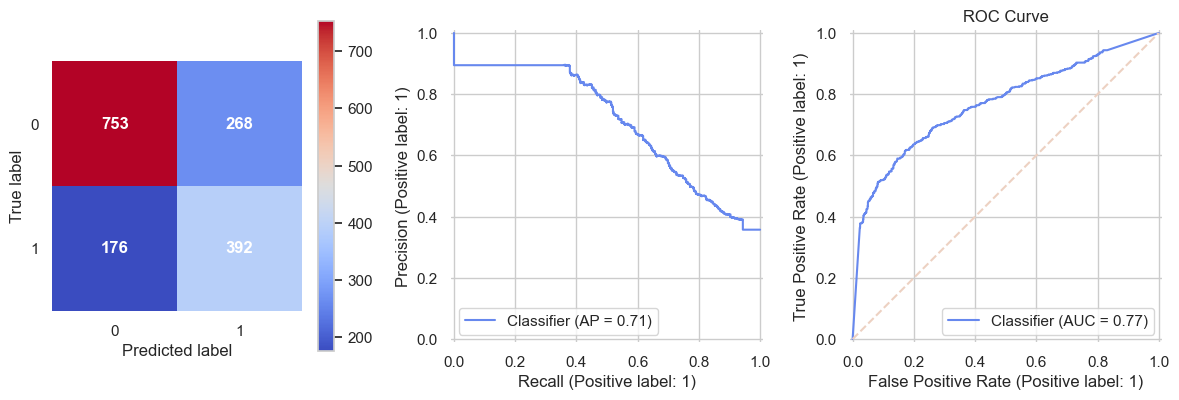

In [38]:
train_X = train_data.drop(columns=["TravelInsurance"])
train_y = train_data["TravelInsurance"]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

y_true_all = []
y_pred_all = []
y_proba_all = []
metrics = {"accuracy": [], "recall": [], "precision": [], "f1": []}

for train_idx, test_idx in kf.split(train_X, train_y):
    X_train_fold, X_test_fold = train_X.iloc[train_idx], train_X.iloc[test_idx]
    y_train_fold, y_test_fold = train_y.iloc[train_idx], train_y.iloc[test_idx]
 
    with warnings.catch_warnings(): 
        warnings.simplefilter("ignore", category=FutureWarning)
        pipe.fit(X_train_fold, y_train_fold)
    y_pred_fold = pipe.predict(X_test_fold)
    y_proba_fold = pipe.predict_proba(X_test_fold)[:, 1]

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)
    y_proba_all.extend(y_proba_fold)

    metrics["accuracy"].append(accuracy_score(y_test_fold, y_pred_fold))
    metrics["recall"].append(
        recall_score(y_test_fold, y_pred_fold, zero_division=0)
    )
    metrics["precision"].append(
        precision_score(y_test_fold, y_pred_fold, zero_division=0)
    )
    metrics["f1"].append(f1_score(y_test_fold, y_pred_fold))

for metric, values in metrics.items():
    print(f"{metric.capitalize():<9} = ",
          f"{np.mean(values):.3f} ± {np.std(values):.3f}")

cm_cv = confusion_matrix(y_true_all, y_pred_all)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ConfusionMatrixDisplay(confusion_matrix=cm_cv).plot(
    ax=ax1, cmap=global_palette, text_kw={"color": "white", "weight": "bold"}
)
ax1.grid(False)
PrecisionRecallDisplay.from_predictions(y_true_all, y_proba_all, ax=ax2)
RocCurveDisplay.from_predictions(y_true_all, y_proba_all, ax=ax3)
ax3.set_title("ROC Curve")
ax3.plot([0, 1], [0, 1], linestyle="--", 
         color=sns.color_palette(global_palette)[-3], 
         label="Random Classifier")
plt.tight_layout();

We can see that it correctly classifies most of the positive labels, but also includes a lot of false positives. This is expected when only 36% of labels are positive in the dataset. Smote really helps here to improve recall without harming precision too much. Considering our focus on recall, the average precision score of 0.71 seems to be a decent result.

Speaking of precision-recall relationship, we could improve recall even further by adjusting the classification threshold, however this would also significantly reduce precision. The exact relationship between these two metrics is plotted below:

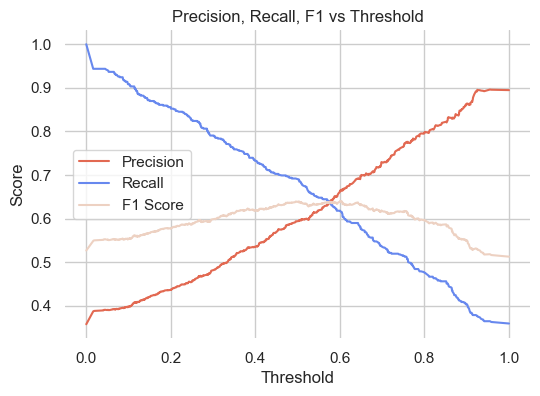

In [39]:
precisions, recalls, thresholds = precision_recall_curve(
    y_true_all, y_proba_all
)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], label="Precision", 
         color=sns.color_palette(global_palette)[-1])
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1s[:-1], label="F1 Score", 
         color=sns.color_palette(global_palette)[3])
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend();

Here we can see that by lowering the threshold, recall would increase, but precision would decrease to a similar degree. Since most customers are unlikely to be interested in travel insurance, the number of false positives would increase much faster than the number of true positives.

For the final decision, we would have to take into consideration the business need of the company and how willing it is to target customers which they know won't be interested in the offered service. For now, we believe the default threshold of 0.5 is good enough to balance recall and precision, but it would certainly make sense to lower the threshold a bit and catch more potentially interested customers, as long as we've willing to accept a higher rate of false positive predictions.

<br>

***

### 3.5. Final model evaluation

Let's predict whether a customer bought travel insurance using the hold-out dataset:

Accuracy  = 0.681
Recall    = 0.669
Precision = 0.543
F1        = 0.599


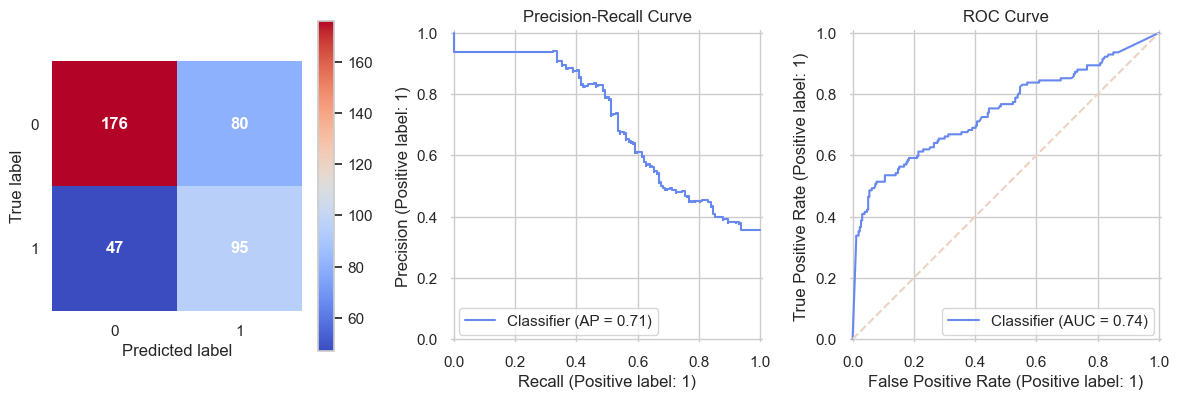

In [40]:
test_X = test_data.drop(columns=["TravelInsurance"])
test_y = test_data["TravelInsurance"]

predictions = pipe.predict(test_X)
proba = pipe.predict_proba(test_X)[:, 1]

metrics = {"accuracy": [], "recall": [], "precision": [], "f1": []}
metrics["accuracy"].append(accuracy_score(test_y, predictions))
metrics["recall"].append(recall_score(test_y, predictions, zero_division=0))
metrics["precision"].append(
    precision_score(test_y, predictions, zero_division=0)
)
metrics["f1"].append(f1_score(test_y, predictions))

for metric, values in metrics.items():
    print(f"{metric.capitalize():<9} = {np.mean(values):.3f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(test_y, predictions)
).plot(ax=ax1, cmap=global_palette, 
       text_kw={"color": "white", "weight": "bold"})
ax1.grid(False)
PrecisionRecallDisplay.from_predictions(test_y, proba, ax=ax2)
ax2.set_title("Precision-Recall Curve")
RocCurveDisplay.from_predictions(test_y, proba, ax=ax3)
ax3.set_title("ROC Curve")
ax3.plot([0, 1], [0, 1], linestyle="--", 
         color=sns.color_palette(global_palette)[-3], 
         label="Random Classifier")
plt.tight_layout();

As expected, the model performs slightly worse on the test data, but the main metric – recall – has lowered by just 0.02, indicating that the model generalises well in predicting true labels. The performance in other metrics drops more significantly, meaning there's relatively more false positives, but this isn't as important minimising false negatives, which is what recall is about.

The precision-recall curve and ROC both remain very similar to what we saw on the training dataset. The average precision remains unchanged, and the AUC score dropped marginally from .77 to .74, again indicating good generalisation of the model.

<br>

***

### 3.6. Opportunities for improvement

- Feature engineering is one tactic we haven't tried here, which might be worth exploring. It's possible that combining some features could help drive recall even further.
- A marginally better result might also be achievable by checking the precision-recall relationship in more models. As we selected the best model based solely on recall, there's no guarantee that a better result is impossible by tuning the threshold of another model which has a slightly worse recall to begin with.